In [1]:
import pymc as pm
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import sys
import arviz as az
import ipywidgets as widgets
import seaborn as sns
from scipy import stats
import preliz as pz
import pytensor as pt

from matplotlib.patches import Patch

sys.path.append("../..")
from src.utils import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# pt.config.optimizer = "None"
# pt.config.exception_verbosity = "high"

In [3]:
total_params = (
    3  # hyperparameters
    + 8  # group-level parameters
    + 5 * 1729  # subject-level parameters
    + 800  # task-level parameters
)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 9456


In [4]:
# polars config
pl.Config.load_from_file("../../polars_cfg.json")

In [5]:
# data file paths
clean_incomplete_path = "../../data/clean_data_incomplete.csv"
clean_data_path = "../../data/clean_data.csv"

clean_summary_path = "../../data/clean_summary_data.csv"
clean_summary_incomplete_path = "../../data/clean_summary_data_incomplete.csv"

In [6]:
df = pl.read_csv(clean_data_path)
df_incomplete = pl.read_csv(clean_incomplete_path)
df_summary = pl.read_csv(clean_summary_path)
df_summary_incomplete = pl.read_csv(clean_summary_incomplete_path)

columns = [
    "exp_name",
    "hashed_id",
    "joint_id_task",
    "task_name",
    "task_number",
    "task_type",
    "attempt_number",
    "action",
    "num_actions",
    "solved",
    "time",
    "test_input_grid",
    "test_output_grid",
]

# include incomplete data
df = pl.concat([df.select(columns), df_incomplete.select(columns)])
df_summary = pl.concat([df_summary, df_summary_incomplete])

# cast time to datetime
df = df.with_columns(pl.col("time").cast(pl.Datetime))

In [7]:
# time to complete tasks
time_to_complete = (
    df.group_by(["joint_id_task"])
    .agg(
        pl.min("time").alias("min_time"),
        pl.max("time").alias("max_time"),
        pl.first("task_name"),
        pl.first("hashed_id"),
        pl.any("solved"),
        pl.first("task_type"),
        pl.max("attempt_number").alias("max_attempt"),
    )
    .with_columns((pl.col("max_time") - pl.col("min_time")).alias("time_to_complete"))
)
# cast time to complete to seconds
time_to_complete = time_to_complete.with_columns(
    pl.col("time_to_complete")
    .map_elements(lambda x: x.total_seconds(), return_dtype=pl.Float64)
    .alias("seconds_to_complete")
)

<Axes: xlabel='seconds_to_complete', ylabel='Count'>

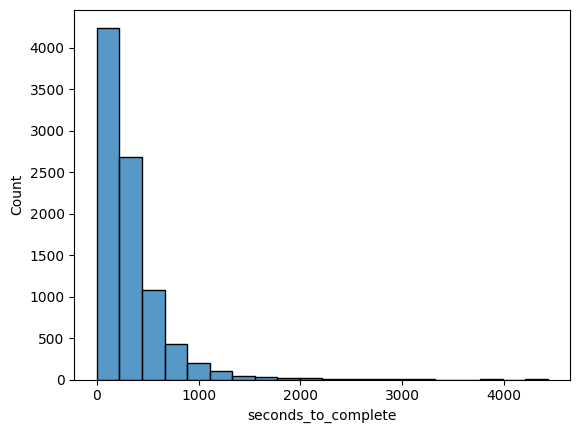

In [8]:
sns.histplot(time_to_complete.to_pandas(), x="seconds_to_complete", bins=20)

<Axes: xlabel='log_seconds_to_complete', ylabel='Count'>

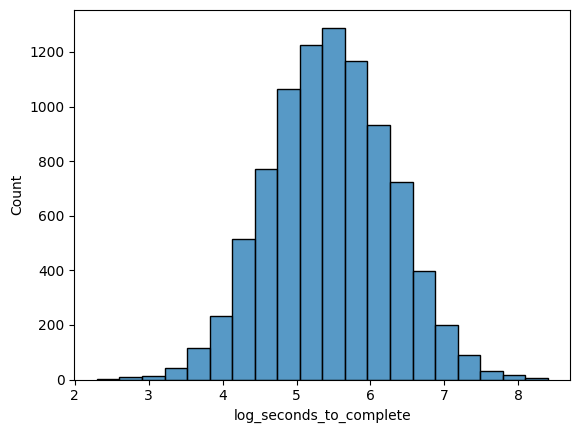

In [9]:
# plot log transformed time to complete
time_to_complete = time_to_complete.with_columns(
    log_seconds_to_complete=pl.col("seconds_to_complete").log()
)
sns.histplot(time_to_complete.to_pandas(), x="log_seconds_to_complete", bins=20)

In [10]:
# filter participants under 15 seconds
time_to_complete = time_to_complete.filter(pl.col("seconds_to_complete") > 15)

In [11]:
# z-score reaction time
time_to_complete = time_to_complete.with_columns(
    z_log_seconds_to_complete=(
        pl.col("log_seconds_to_complete") - pl.col("log_seconds_to_complete").mean()
    )
    / pl.col("log_seconds_to_complete").std()
)

In [12]:
time_to_complete.head()

joint_id_task,min_time,max_time,task_name,hashed_id,solved,task_type,max_attempt,time_to_complete,seconds_to_complete,log_seconds_to_complete,z_log_seconds_to_complete
str,datetime[μs],datetime[μs],str,str,bool,str,i64,duration[μs],f64,f64,f64
"""7c80590e804169d56bc51fc41cb0d795_d89b689b.jso…",2024-02-25 05:00:30,2024-02-25 05:02:17,"""d89b689b.json""","""7c80590e804169d56bc51fc41cb0d795""",true,"""training""",1,1m 47s,107.0,4.672829,-0.971346
"""59785c8a3b558c1c1d6bc1448c1e4141_234bbc79.jso…",2024-02-28 11:13:11,2024-02-28 11:18:04,"""234bbc79.json""","""59785c8a3b558c1c1d6bc1448c1e4141""",true,"""training""",3,4m 53s,293.0,5.680173,0.277778
"""26fd7f7aee49ba528d0821d9090b8985_29c11459.jso…",2024-02-22 22:31:40,2024-02-22 22:33:22,"""29c11459.json""","""26fd7f7aee49ba528d0821d9090b8985""",true,"""training""",1,1m 42s,102.0,4.624973,-1.030688
"""f9e09165f1e1ff303e547946790fc10e_f5aa3634.jso…",2024-07-26 16:40:52,2024-07-26 16:44:17,"""f5aa3634.json""","""f9e09165f1e1ff303e547946790fc10e""",false,"""evaluation""",3,3m 25s,205.0,5.32301,-0.16511
"""be5d9b8294ca6201040dbd925ee33a58_95990924.jso…",2024-03-01 16:56:04,2024-03-01 16:58:17,"""95990924.json""","""be5d9b8294ca6201040dbd925ee33a58""",true,"""training""",1,2m 13s,133.0,4.890349,-0.701617


In [13]:
time_to_complete.filter(pl.col("seconds_to_complete").is_null()).shape

(0, 12)

In [14]:
time_to_complete = time_to_complete.filter(pl.col("seconds_to_complete").is_not_null())

In [15]:
def simulate_performance_with_irt_rt_alt(df, n_samples=5000, tune=1000):

    # create indices for participants
    participants_idx, participants = pd.factorize(df["hashed_id"], sort=True)

    # create task index
    task_idx, tasks = pd.factorize(df["task_name"], sort=True)

    # task type
    task_type_idx, task_types = pd.factorize(
        df["task_type"], sort=True
    )  # sorted means evaluation=0, training=1

    # training and eval tasks
    training_task_idx = task_idx[task_type_idx == 1]
    training_task_idx = np.unique(training_task_idx)
    training_tasks = tasks[training_task_idx]
    eval_task_idx = task_idx[task_type_idx == 0]
    eval_task_idx = np.unique(eval_task_idx)
    eval_tasks = tasks[eval_task_idx]

    # training and eval participants
    training_participants_idx = participants_idx[task_type_idx == 1]
    training_participants_idx = np.unique(training_participants_idx)
    eval_participants_idx = participants_idx[task_type_idx == 0]
    eval_participants_idx = np.unique(eval_participants_idx)

    # coords
    coords = {
        "participants": participants,
        "tasks": tasks,
        "obs": np.arange(len(df)),
        "training_tasks": training_tasks,
        "eval_tasks": eval_tasks,
    }

    # hierarchical model
    with pm.Model(coords=coords) as model:

        # hyper priors
        v_intercept = pm.Exponential("v_intercept", 1)
        v_slope = pm.Exponential("v_slope", 1)
        v_acc = pm.Exponential("v_acc", 1)
        rt_std = pm.Exponential("rt_std", 0.1)
        # Separate hyperpriors for different parameter groups
        # v_rt = pm.HalfNormal("v_rt", sigma=1)  # For RT parameters
        # v_acc = pm.HalfNormal("v_acc", sigma=1)  # For accuracy parameters
        # rt_std = pm.HalfNormal("rt_std", sigma=1)

        # priors
        rt_intercept_group = pm.Normal("rt_intercept_group", mu=0, sigma=3)
        rt_intercept_subject = pm.Normal(
            "rt_intercept_subject", mu=0, sigma=v_intercept, dims="participants"
        )

        rt_slope_group = pm.Normal("rt_slope_group", mu=0, sigma=3)
        rt_slope_subject = pm.Normal(
            "rt_slope_subject", mu=0, sigma=v_slope, dims="participants"
        )

        item_difficulty = pm.Normal("item_difficulty", mu=0, sigma=1, dims="tasks")

        mean_rt = (rt_intercept_group + rt_intercept_subject[participants_idx]) + (
            rt_slope_group + rt_slope_subject[participants_idx]
        ) * item_difficulty[task_idx]

        rt = pm.Normal(
            "rt",
            mu=mean_rt,
            sigma=rt_std,
            observed=df["log_seconds_to_complete"],
            dims="obs",
        )

        acc_intercept_group = pm.Normal("acc_intercept_group", mu=0, sigma=3)
        acc_intercept_subject = pm.Normal(
            "acc_intercept_subject", mu=0, sigma=v, dims="participants"
        )

        rt_effect_group = pm.Normal("rt_effect_group", mu=0, sigma=3)
        rt_effect_subject = pm.Normal(
            "rt_effect_subject", mu=0, sigma=v, dims="participants"
        )

        diff_effect_group = pm.Normal("diff_effect_group", mu=0, sigma=3)
        diff_effect_subject = pm.Normal(
            "diff_effect_subject", mu=0, sigma=v, dims="participants"
        )

        time_investment_effect = pm.Normal("time_investment", mu=0, sigma=3)
        rt_reponse_to_diff_effect = pm.Normal("rt_response_to_diff", mu=0, sigma=3)

        interaction_time_investment_rt_response_to_diff = pm.Normal(
            "interaction_time_investment_rt_response_to_diff",
            mu=0,
            sigma=3,
        )
        p = pm.math.invlogit(
            (acc_intercept_group + acc_intercept_subject[participants_idx])
            + (rt_effect_group + rt_effect_subject[participants_idx]) * rt
            + (diff_effect_group + diff_effect_subject[participants_idx])
            * item_difficulty[task_idx]
            + (time_investment_effect * rt_intercept_subject[participants_idx])
            + (rt_reponse_to_diff_effect * rt_slope_subject[participants_idx])
            + (
                interaction_time_investment_rt_response_to_diff
                * rt_intercept_subject[participants_idx]
                * rt_slope_subject[participants_idx]
            )
        )

        pm.Bernoulli("outcomes", p=p, observed=df["solved"], dims="obs")

        # Sampling
        trace = pm.sample(
            n_samples,
            tune=tune,
            return_inferencedata=True,
            target_accept=0.95,
        )

    return model, trace

In [16]:
def simulate_performance_with_irt_rt(
    df, n_samples=5000, tune=1000, quick_n_dirty=False, prior_predictive=False
):

    # create indices for participants
    participants_idx, participants = pd.factorize(df["hashed_id"], sort=True)

    # create task index
    task_idx, tasks = pd.factorize(df["task_name"], sort=True)

    # task type
    task_type_idx, task_types = pd.factorize(
        df["task_type"], sort=True
    )  # sorted means evaluation=0, training=1

    # training and eval tasks
    training_task_idx = task_idx[task_type_idx == 1]
    training_task_idx = np.unique(training_task_idx)
    training_tasks = tasks[training_task_idx]
    eval_task_idx = task_idx[task_type_idx == 0]
    eval_task_idx = np.unique(eval_task_idx)
    eval_tasks = tasks[eval_task_idx]

    # training and eval participants
    training_participants_idx = participants_idx[task_type_idx == 1]
    training_participants_idx = np.unique(training_participants_idx)
    eval_participants_idx = participants_idx[task_type_idx == 0]
    eval_participants_idx = np.unique(eval_participants_idx)

    # coords
    coords = {
        "participants": participants,
        "tasks": tasks,
        "obs": np.arange(len(df)),
        "training_tasks": training_tasks,
        "eval_tasks": eval_tasks,
    }

    # hierarchical model
    with pm.Model(coords=coords) as model:

        SD = 1
        ER = 2

        gamma0 = pm.Normal("gamma0", mu=0, sigma=1, dims="participants")
        gamma0_m = pm.Normal("gamma0_m", mu=0, sigma=SD)
        gamma0_s = pm.HalfNormal("gamma0_s", sigma=SD)

        gamma1 = pm.Normal("gamma1", mu=0, sigma=1, dims="participants")
        gamma1_m = pm.Normal("gamma1_m", mu=0, sigma=SD)
        gamma1_s = pm.HalfNormal("gamma1_s", sigma=SD)

        gamma2 = pm.Normal("gamma2", mu=0, sigma=1, dims="participants")
        gamma2_m = pm.Normal("gamma2_m", mu=0, sigma=SD)
        gamma2_s = pm.HalfNormal("gamma2_s", sigma=SD)

        beta0 = pm.Normal("beta0", mu=0, sigma=1, dims="participants")
        beta0_m = pm.Normal("beta0_m", mu=0, sigma=SD)
        beta0_s = pm.HalfNormal("beta0_s", sigma=SD)

        beta1 = pm.Normal("beta1", mu=0, sigma=1, dims="participants")
        beta1_m = pm.Normal("beta1_m", mu=0, sigma=SD)
        beta1_s = pm.HalfNormal("beta1_s", sigma=SD)

        # rt_scale = pm.Exponential("rt_scale", ER)
        rt_scale = pm.HalfNormal("rt_scale", SD)
        difficulty = pm.Normal("difficulty", mu=0, sigma=1, dims="tasks")

        rtIcptEffect = pm.Normal("rtIcptEffect", mu=0, sigma=SD)
        rtSlopeEffect = pm.Normal("rtSlopeEffect", mu=0, sigma=SD)
        rtInteraction = pm.Normal("rtInteraction", mu=0, sigma=SD)

        s_gamma0 = pm.Deterministic(
            "s_gamma0", gamma0_m + gamma0_s * gamma0, dims="participants"
        )
        s_gamma1 = pm.Deterministic(
            "s_gamma1", gamma1_m + gamma1_s * gamma1, dims="participants"
        )
        s_gamma2 = pm.Deterministic(
            "s_gamma2", gamma2_m + gamma2_s * gamma2, dims="participants"
        )

        s_beta0 = pm.Deterministic(
            "s_beta0", beta0_m + beta0_s * beta0, dims="participants"
        )
        s_beta1 = pm.Deterministic(
            "s_beta1", beta1_m + beta1_s * beta1, dims="participants"
        )

        rt_m = (
            s_beta0[participants_idx] + s_beta1[participants_idx] * difficulty[task_idx]
        )

        rt_z = pm.Normal(
            "rt_z",
            mu=rt_m,
            sigma=rt_scale,
            observed=df["z_log_seconds_to_complete"],
            dims="obs",
        )

        p = pm.math.invlogit(
            s_gamma0[participants_idx]
            + s_gamma1[participants_idx] * rt_z
            + s_gamma2[participants_idx] * difficulty[task_idx]
            + rtIcptEffect * beta0[participants_idx]
            + rtSlopeEffect * beta1[participants_idx]
            + rtInteraction * beta0[participants_idx] * beta1[participants_idx]
        )

        pm.Bernoulli("outcomes", p=p, observed=df["solved"], dims="obs")

        if prior_predictive:
            trace = pm.sample_prior_predictive(samples=n_samples)
        elif quick_n_dirty:
            approx = pm.fit(n=n_samples, method="advi")
            trace = approx.sample(n_samples)
        else:
            trace = pm.sample(
                n_samples, tune=tune, return_inferencedata=True, target_accept=0.95
            )

    return model, trace

I tried the following models:

0. Fit original model with from P paper with 5k samples and 1k tuning
1. Fit the original model from Piantadosi paper, with common Exponential hyperprior on std with 10000 samples and 4000 tuning samples -- convergence issues
2. Increase target accept to 0.95 -- convergence issues
3. Separate hyperpriors for different parameter groups and make them HalfNormal instead of Exponential and decrease variance of Normal dist
4. Project RT into log space and run v3 with 5k samples and 1k tuning
5. Model 2 with smaller variances in Normal dist


In [36]:
model, trace = simulate_performance_with_irt_rt(
    time_to_complete.to_pandas(), n_samples=2500, tune=500, prior_predictive=True
)

Sampling: [beta0, beta0_m, beta0_s, beta1, beta1_m, beta1_s, difficulty, gamma0, gamma0_m, gamma0_s, gamma1, gamma1_m, gamma1_s, gamma2, gamma2_m, gamma2_s, outcomes, rtIcptEffect, rtInteraction, rtSlopeEffect, rt_scale, rt_z]


array([<Axes: xlabel='rt_z'>, <Axes: xlabel='outcomes'>], dtype=object)

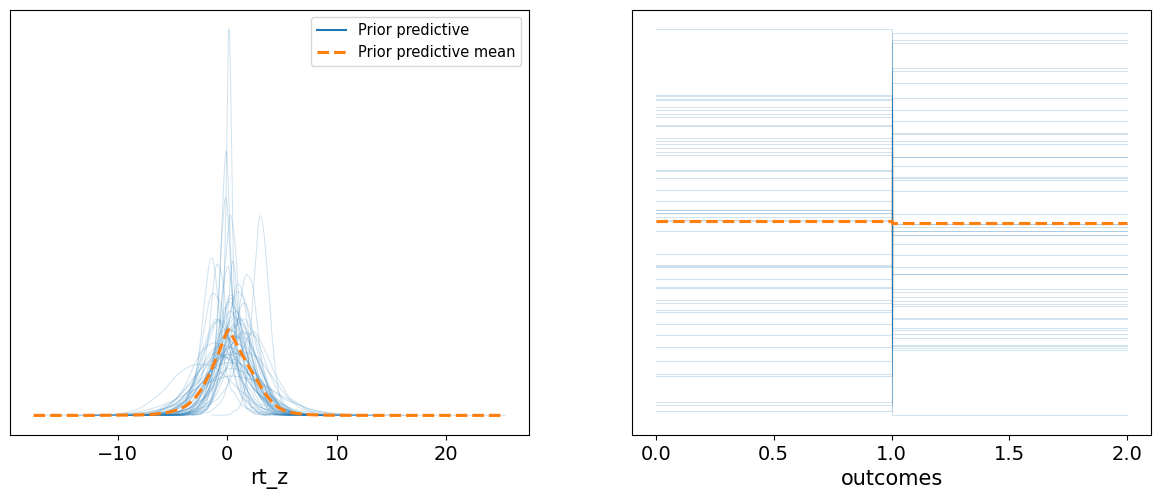

In [37]:
az.plot_ppc(
    trace,
    num_pp_samples=50,
    kind="kde",
    var_names=["rt_z", "outcomes"],
    group="prior",
)

In [33]:
model, trace = simulate_performance_with_irt_rt(
    time_to_complete.to_pandas(), n_samples=20000, tune=1000, quick_n_dirty=True
)

Output()

Finished [100%]: Average Loss = 15,365


In [17]:
model, trace = simulate_performance_with_irt_rt(
    time_to_complete.to_pandas(), n_samples=5000, tune=2000
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma0, gamma0_m, gamma0_s, gamma1, gamma1_m, gamma1_s, gamma2, gamma2_m, gamma2_s, beta0, beta0_m, beta0_s, beta1, beta1_m, beta1_s, rt_scale, difficulty, rtIcptEffect, rtSlopeEffect, rtInteraction]


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 981 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


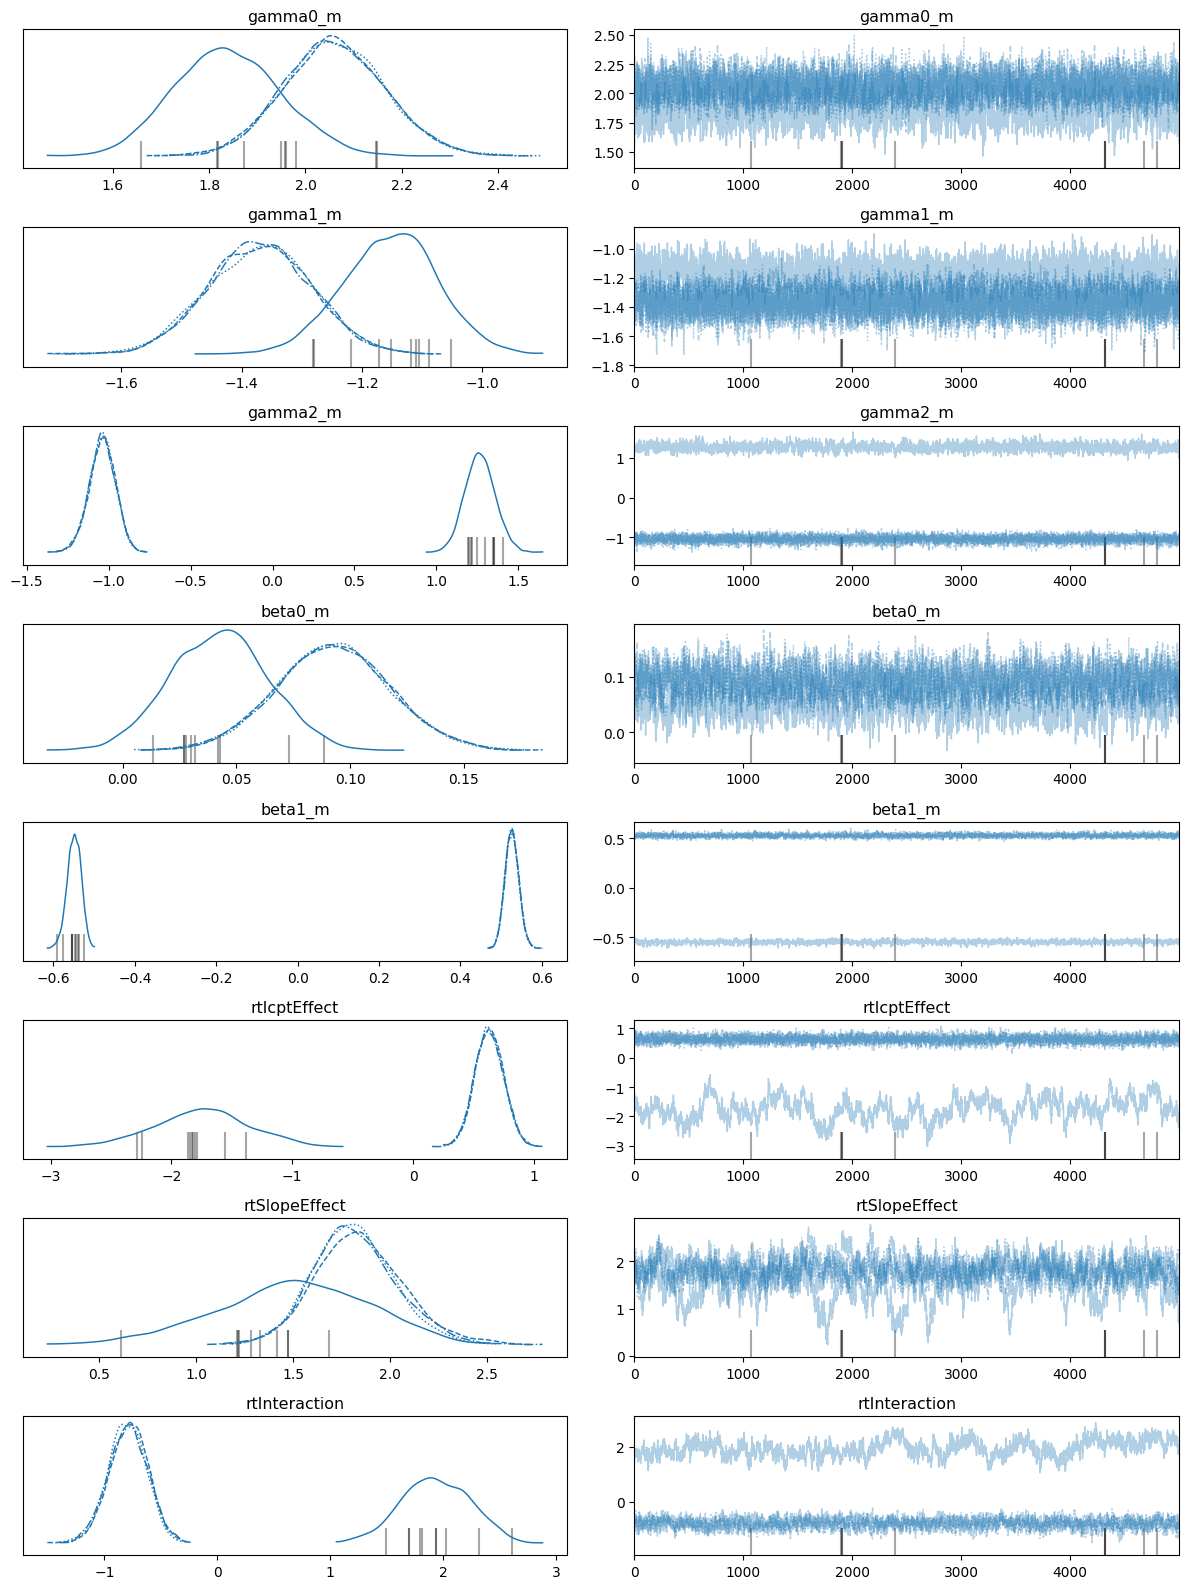

In [18]:
az.plot_trace(
    trace,
    var_names=[
        "gamma0_m",  # base accuracy intercept
        "gamma1_m",  # RT effect on accuracy
        "gamma2_m",  # difficulty effect on accuracy
        "beta0_m",  # RT intercept
        "beta1_m",  # RT slope
        "rtIcptEffect",  # RT intercept effect on accuracy
        "rtSlopeEffect",  # RT slope effect on accuracy
        "rtInteraction",  # interaction between RT intercept and slope
    ],
)
plt.tight_layout()
plt.show()

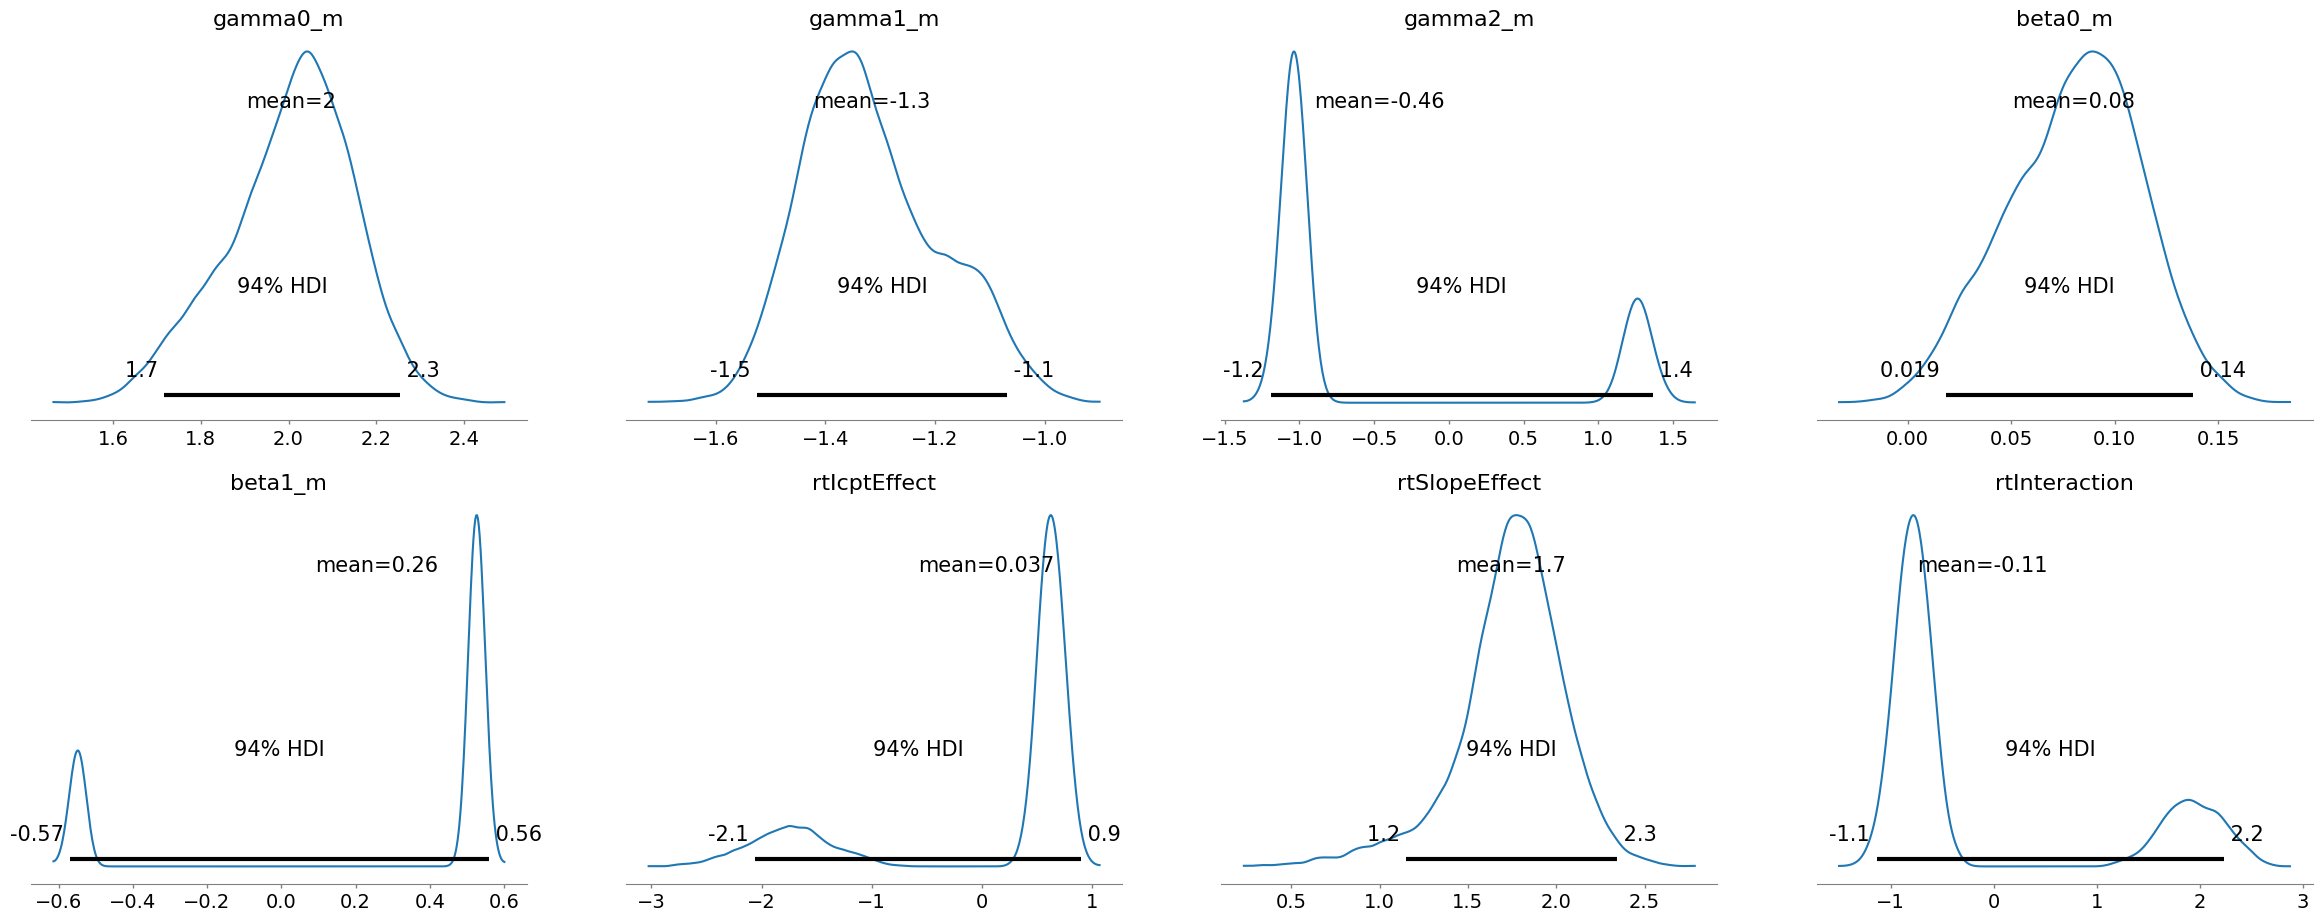

In [20]:
az.plot_posterior(
    trace,
    var_names=[
        "gamma0_m",  # base accuracy intercept
        "gamma1_m",  # RT effect on accuracy
        "gamma2_m",  # difficulty effect on accuracy
        "beta0_m",  # RT intercept
        "beta1_m",  # RT slope
        "rtIcptEffect",  # RT intercept effect on accuracy
        "rtSlopeEffect",  # RT slope effect on accuracy
        "rtInteraction",  # interaction between RT intercept and slope
    ],
)
plt.show()

In [25]:
# proportion solved per participant
participants_max_tasks = df_summary.group_by("hashed_id").agg(
    pl.max("task_number"), pl.first("task_type")
)
participants_max_tasks = participants_max_tasks.rename(
    {"task_number": "max_task_number"}
)
df_summary_ = df_summary.join(participants_max_tasks, on="hashed_id")
participant_success = df_summary_.group_by("hashed_id").agg(
    pl.sum("solved") / pl.max("max_task_number")
)

In [26]:
participant_success = participant_success.filter(
    pl.col("hashed_id").is_in(time_to_complete["hashed_id"])
)

In [27]:
# only keep participants in participant_success
trace = trace.sel(
    participants=participant_success["hashed_id"].to_numpy(),
    dims={"participants": ["hashed_id"]},
)

In [42]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [43]:
trace.posterior["gamma0"]

<xarray.DataArray 'gamma0' (chain: 4, draw: 5000, participants: 1723)> Size: 276MB
array([[[ 0.09796196, -0.04971293, -1.73814519, ..., -0.05994141,
          0.47556552, -0.64429951],
        [ 0.48758014,  0.2423994 , -2.25376427, ..., -0.22019878,
          0.20043755, -0.44520612],
        [-0.60264115, -0.05361296, -1.13516619, ..., -1.19716966,
         -1.28463969, -0.71929049],
        ...,
        [-0.684739  , -1.08748664,  1.34476425, ...,  1.1081487 ,
         -1.41121544, -0.25758202],
        [-0.45341262, -0.58440875,  3.3125751 , ...,  0.5733151 ,
         -0.02960575,  0.78572693],
        [ 1.35608287, -0.31652361, -1.1210421 , ...,  0.79709188,
         -0.12768316,  0.62473291]],

       [[ 0.51648111, -0.06998782, -0.86028203, ..., -0.85640045,
          0.33163201, -0.06493519],
        [ 1.68257559, -0.94358331, -0.62489832, ..., -1.36086155,
         -0.11415857, -0.04410472],
        [-0.4472279 ,  0.82145366,  0.08643757, ..., -0.05294984,
          0.07990452,  0.32894645],
...
        [ 0.51367224, -0.3759979 , -0.04169841, ..., -0.84273423,
         -0.88300661, -1.20504779],
        [-0.17757615,  0.22463044, -0.24991838, ..., -0.22276867,
          0.75421631, -0.08302504],
        [ 0.16476908,  0.08918993,  0.17050324, ...,  0.35640949,
         -0.66639372, -0.10444644]],

       [[ 1.57974286, -1.60740745, -0.16155561, ..., -2.0450057 ,
          0.57607289, -1.25447767],
        [ 1.14644217,  0.21765798,  0.68785846, ..., -2.48083948,
          1.45067392, -1.43333254],
        [-0.19601688,  0.37083578, -1.08748279, ...,  0.55025876,
         -1.51620672,  0.73964697],
        ...,
        [ 1.89263881,  0.18772811, -0.7385748 , ..., -1.627234  ,
         -0.89590162, -0.22425611],
        [ 1.72161859, -0.12900067,  0.23007114, ..., -1.03169948,
         -0.29208756, -0.82840746],
        [ 0.2730644 , -0.18336167,  0.24517151, ...,  0.25005912,
          1.36778835,  0.57253041]]])
Coordinates:
  * chain         (chain) int64 32B 0 1 2 3
  * draw          (draw) int64 40kB 0 1 2 3 4 5 ... 4995 4996 4997 4998 4999
  * participants  (participants) <U32 221kB 'f0fc45c662ed5813d755d6cc9e2af0d3...

In [47]:
trace.posterior["gamma0"].coords

Coordinates:
  * chain         (chain) int64 32B 0 1 2 3
  * draw          (draw) int64 40kB 0 1 2 3 4 5 ... 4995 4996 4997 4998 4999
  * participants  (participants) <U32 221kB 'f0fc45c662ed5813d755d6cc9e2af0d3...

In [53]:
gamma_zero = trace.posterior["s_gamma0"]

In [55]:
gamma_zero

<xarray.DataArray 's_gamma0' (chain: 4, draw: 5000, s_gamma0_dim_0: 1740)> Size: 278MB
array([[[ 0.87157299,  0.78633998,  1.60637869, ...,  1.26604656,
          1.4304258 ,  2.03868215],
        [ 0.78489547,  0.83651458,  1.78981021, ...,  1.52488311,
          1.19650418,  1.81021381],
        [ 1.43182765,  1.62767089,  1.6291336 , ...,  1.26231258,
          1.5155184 ,  1.67930092],
        ...,
        [ 2.21431775,  3.23028845,  1.82869718, ...,  1.90425042,
          2.02385286,  2.41312293],
        [ 2.11433878,  1.67797285,  1.98071   , ...,  1.55721206,
          1.7707836 ,  2.77760012],
        [ 0.81236406,  2.15113359,  0.88704783, ...,  0.09739911,
          1.97353794,  0.96383315]],

       [[ 1.67405556,  2.60364504, -2.23010888, ...,  0.82769592,
         -0.67365177,  1.72651697],
        [ 1.20024952,  1.3961127 , -2.46745671, ...,  2.09753301,
         -0.51871759,  3.68244372],
        [ 1.81757989,  2.46587764,  3.28307548, ...,  1.6439019 ,
          5.22394427,  0.71998931],
...
        [ 3.09318024,  0.91708982,  3.51189072, ..., -1.36399453,
          0.33369424,  2.22875843],
        [-2.03272184,  2.42272658,  1.94584748, ...,  2.91214055,
          4.07349388,  1.77377992],
        [-0.61195778,  4.04444844,  2.1846539 , ...,  1.93269321,
          3.31737304,  3.18569189]],

       [[ 0.01283774,  3.14564698,  4.56826367, ...,  1.01440128,
          2.53429658,  1.5699308 ],
        [-0.75925283,  3.35127554,  1.20081993, ..., -0.13910286,
          2.89347348,  1.39016349],
        [ 2.09244901,  2.05396636,  0.23554501, ...,  2.77061197,
          1.63342016,  3.24128826],
        ...,
        [ 0.56645583,  3.2595954 , -3.05289754, ...,  1.13287879,
         -1.80289297,  0.21008661],
        [-0.02050913,  2.8493898 , -2.12044338, ...,  1.02085874,
         -0.81130133,  0.38961615],
        [ 0.88901198,  3.46593473, -0.18706879, ..., -0.38325283,
          5.25113661,  3.49520626]]])
Coordinates:
  * chain           (chain) int64 32B 0 1 2 3
  * draw            (draw) int64 40kB 0 1 2 3 4 5 ... 4995 4996 4997 4998 4999
  * s_gamma0_dim_0  (s_gamma0_dim_0) int64 14kB 0 1 2 3 ... 1736 1737 1738 1739

In [48]:
gamma_zero = trace.posterior["s_gamma0"]
# # change variable name
# gamma_zero = gamma_zero.rename("gamma")
gamma_zero_hdi = az.hdi(gamma_zero, hdi_prob=0.94)
participants = gamma_zero.coords["participants"].values.flatten()
gamma_zero_values = gamma_zero.mean(dim=["chain", "draw"]).values.flatten()

KeyError: 'participants'

In [36]:
# order participants df by participants
participant_success_values = (
    participant_success.to_pandas()
    .set_index("hashed_id")
    .loc[participants]
    .values.flatten()
)

# Create DataFrame for plotting
plot_df_gamma_zero = pd.DataFrame(
    {
        "hashed_id": participants,
        "acc_intercept": gamma_zero_values,
        "hdi_lower": gamma_zero_hdi.sel(hdi="lower").gamma.values,
        "hdi_upper": gamma_zero_hdi.sel(hdi="higher").gamma.values,
        "success_rate": participant_success_values,
    }
)

# Add jitter to success rates to avoid overlapping
jitter = np.random.normal(0, 0.01, len(plot_df_gamma_zero["success_rate"]))
jittered_success_rate_ability = plot_df_gamma_zero["success_rate"] + jitter

x_trend = np.linspace(0, 1, 100)
p = np.poly1d(
    np.polyfit(jittered_success_rate_ability, plot_df_gamma_zero["acc_intercept"], 1)
)
correlation = np.corrcoef(
    jittered_success_rate_ability, plot_df_gamma_zero["acc_intercept"]
)[0, 1]

KeyError: "None of [Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,\n       ...\n       1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739],\n      dtype='int64', name='hashed_id', length=1740)] are in the [index]"

NameError: name 'jittered_success_rate_ability' is not defined

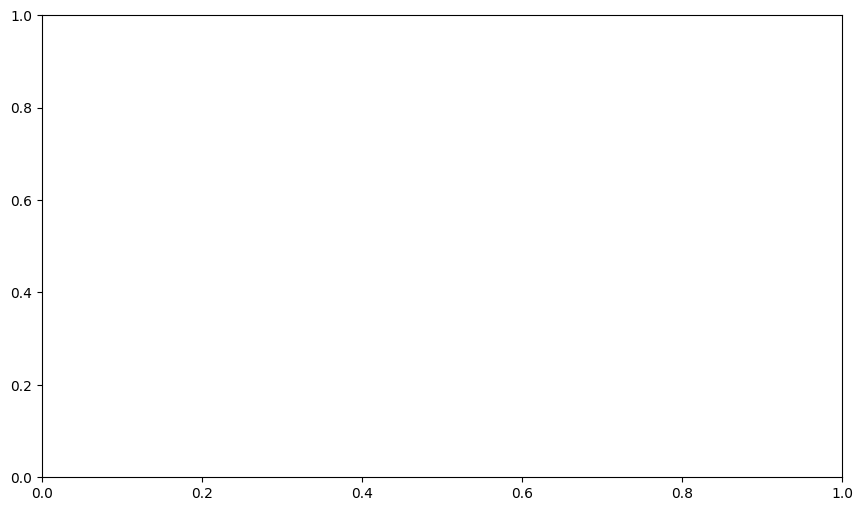

In [37]:
# Create figure and gridspec
fig = plt.figure(figsize=(12, 6))
gs = plt.GridSpec(1, 3, width_ratios=[5, 5, 1])  # Adjust width ratios as needed

# Create the scatter plot in the main area
ax_main = fig.add_subplot(gs[0:2])  # Use first two columns

# Create main scatter plot with smaller points and lower alpha
ax_main.scatter(
    jittered_success_rate_ability,
    plot_df_gamma_zero["acc_intercept"],
    s=20,
    alpha=0.4,
    color="black",
    zorder=2,
)

# Add error bars
ax_main.errorbar(
    jittered_success_rate_ability,
    plot_df_gamma_zero["acc_intercept"],
    yerr=[
        plot_df_gamma_zero["acc_intercept"] - plot_df_gamma_zero["hdi_lower"],
        plot_df_gamma_zero["hdi_upper"] - plot_df_gamma_zero["acc_intercept"],
    ],
    fmt="none",
    ecolor="gray",
    alpha=0.2,
    zorder=1,
)

# Add trend line
# ax_main.plot(x_trend, p(x_trend), "r--", alpha=0.5, zorder=3)

# Add correlation text
ax_main.text(
    0.05,
    0.95,
    f"r = {correlation:.3f}",
    transform=ax_main.transAxes,
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.8),
)

ax_main.set_xlabel("Mean success rate")
# ax_main.set_ylabel("Ability (alpha)")
# alpha as latex
ax_main.set_ylabel(r"$\gamma_0 + \gamma_{s0}$")
ax_main.grid(True, alpha=0.2)

# add dotted line
ax_main.axhline(0, color="black", linestyle="--", alpha=0.2)

# Create the y-axis KDE
ax_right = fig.add_subplot(gs[2])
sns.kdeplot(
    y=plot_df_gamma_zero["acc_intercept"],
    ax=ax_right,
    fill=True,
    color="black",
    alpha=0.1,
)
ax_right.set_yticklabels([])
ax_right.set_xticklabels([])
ax_right.set_xlabel("")
ax_right.set_ylabel("")
# remove spines
ax_right.spines["left"].set_visible(False)
ax_right.spines["top"].set_visible(False)
ax_right.spines["right"].set_visible(False)
ax_right.spines["bottom"].set_visible(False)
# remove ticks
ax_right.tick_params(axis="y", left=False)
ax_right.tick_params(axis="x", bottom=False)


# Match limits
ax_right.set_ylim(ax_main.get_ylim())


plt.tight_layout()
plt.show()

In [26]:
posterior_gamma_one = trace.posterior["s_gamma1"]
# change variable name
posterior_gamma_one = posterior_gamma_one.rename("gamma_one")
posterior_gamma_one_hdi = az.hdi(posterior_gamma_one, hdi_prob=0.94)
posterior_gamma_one_values = posterior_gamma_one.mean(
    dim=["chain", "draw"]
).values.flatten()

In [27]:
# Create DataFrame for plotting
plot_df_gamma_one = pd.DataFrame(
    {
        "hashed_id": participants,
        "acc_slope": posterior_gamma_one_values,
        "hdi_lower": posterior_gamma_one_hdi.sel(hdi="lower").gamma_one.values,
        "hdi_upper": posterior_gamma_one_hdi.sel(hdi="higher").gamma_one.values,
        "success_rate": participant_success_values,
    }
)

# Add jitter to success rates to avoid overlapping
jitter = np.random.normal(0, 0.01, len(plot_df_gamma_one["success_rate"]))
jittered_success_rate_ability = plot_df_gamma_one["success_rate"] + jitter

x_trend = np.linspace(0, 1, 100)
p = np.poly1d(
    np.polyfit(jittered_success_rate_ability, plot_df_gamma_one["acc_slope"], 1)
)
correlation = np.corrcoef(
    jittered_success_rate_ability, plot_df_gamma_one["acc_slope"]
)[0, 1]

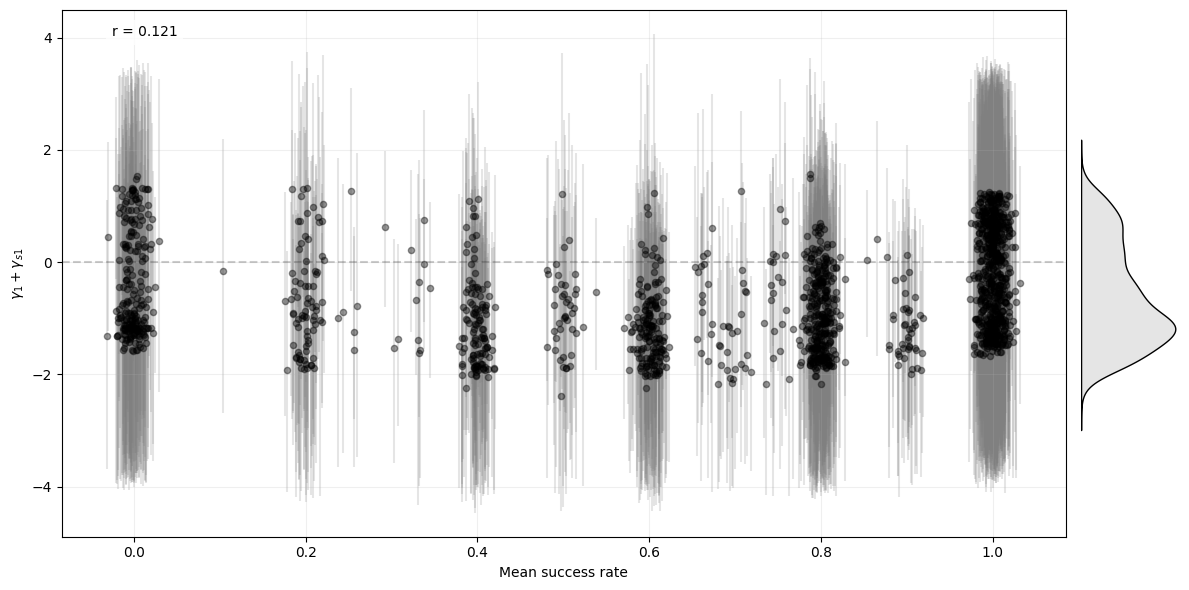

In [28]:
# Create figure and gridspec
fig = plt.figure(figsize=(12, 6))
gs = plt.GridSpec(1, 3, width_ratios=[5, 5, 1])  # Adjust width ratios as needed

# Create the scatter plot in the main area
ax_main = fig.add_subplot(gs[0:2])  # Use first two columns

# Create main scatter plot with smaller points and lower alpha
ax_main.scatter(
    jittered_success_rate_ability,
    plot_df_gamma_one["acc_slope"],
    s=20,
    alpha=0.4,
    color="black",
    zorder=2,
)

# Add error bars
ax_main.errorbar(
    jittered_success_rate_ability,
    plot_df_gamma_one["acc_slope"],
    yerr=[
        plot_df_gamma_one["acc_slope"] - plot_df_gamma_one["hdi_lower"],
        plot_df_gamma_one["hdi_upper"] - plot_df_gamma_one["acc_slope"],
    ],
    fmt="none",
    ecolor="gray",
    alpha=0.2,
    zorder=1,
)

# Add trend line
# ax_main.plot(x_trend, p(x_trend), "r--", alpha=0.5, zorder=3)

# Add correlation text
ax_main.text(
    0.05,
    0.95,
    f"r = {correlation:.3f}",
    transform=ax_main.transAxes,
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.8),
)

ax_main.set_xlabel("Mean success rate")
# ax_main.set_ylabel("Ability (alpha)")
# alpha as latex
ax_main.set_ylabel(r"$\gamma_1 + \gamma_{s1}$")
ax_main.grid(True, alpha=0.2)

# add dotted line
ax_main.axhline(0, color="black", linestyle="--", alpha=0.2)

# Create the y-axis KDE
ax_right = fig.add_subplot(gs[2])
sns.kdeplot(
    y=plot_df_gamma_one["acc_slope"],
    ax=ax_right,
    fill=True,
    color="black",
    alpha=0.1,
)
ax_right.set_yticklabels([])
ax_right.set_xticklabels([])
ax_right.set_xlabel("")
ax_right.set_ylabel("")
# remove spines
ax_right.spines["left"].set_visible(False)
ax_right.spines["top"].set_visible(False)
ax_right.spines["right"].set_visible(False)
ax_right.spines["bottom"].set_visible(False)
# remove ticks
ax_right.tick_params(axis="y", left=False)
ax_right.tick_params(axis="x", bottom=False)


# Match limits
ax_right.set_ylim(ax_main.get_ylim())


plt.tight_layout()
plt.show()

In [29]:
posterior_beta_one = trace.posterior["beta1"]
# change variable name
posterior_beta_one = posterior_beta_one.rename("beta_one")
posterior_beta_one_hdi = az.hdi(posterior_beta_one, hdi_prob=0.94)
posterior_beta_one_values = posterior_beta_one.mean(
    dim=["chain", "draw"]
).values.flatten()

# Create DataFrame for plotting
plot_df_beta_one = pd.DataFrame(
    {
        "hashed_id": participants,
        "rt_slope": posterior_beta_one_values,
        "hdi_lower": posterior_beta_one_hdi.sel(hdi="lower").beta_one.values,
        "hdi_upper": posterior_beta_one_hdi.sel(hdi="higher").beta_one.values,
        "success_rate": participant_success_values,
    }
)

# Add jitter to success rates to avoid overlapping
jitter = np.random.normal(0, 0.01, len(plot_df_beta_one["success_rate"]))
jittered_success_rate_ability = plot_df_beta_one["success_rate"] + jitter

x_trend = np.linspace(0, 1, 100)
p = np.poly1d(
    np.polyfit(jittered_success_rate_ability, plot_df_beta_one["rt_slope"], 1)
)
correlation = np.corrcoef(jittered_success_rate_ability, plot_df_beta_one["rt_slope"])[
    0, 1
]

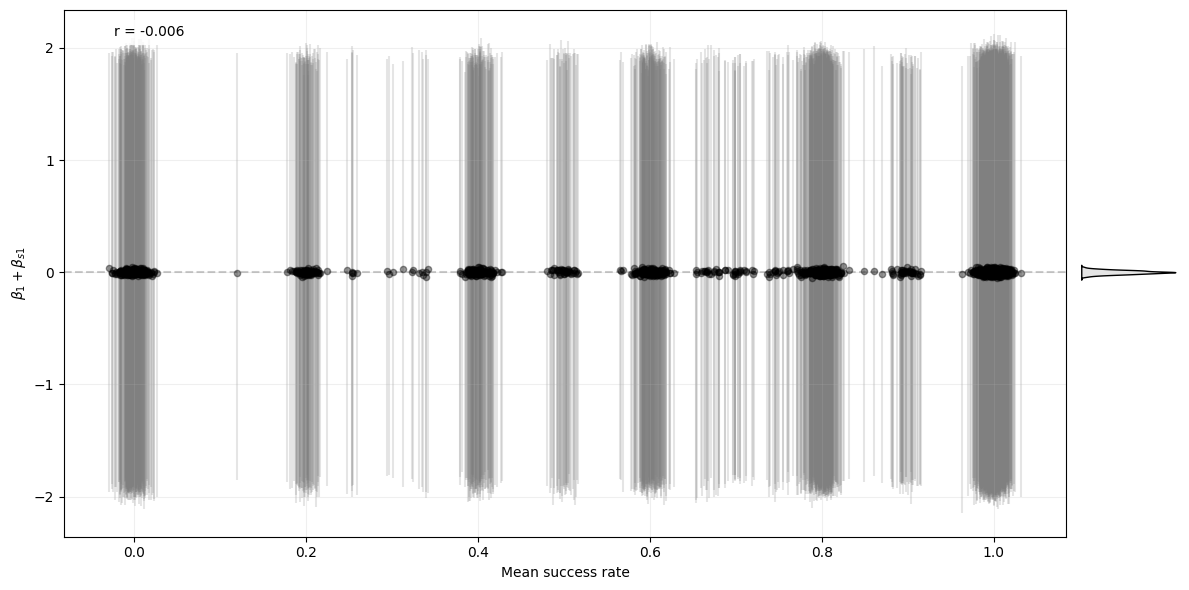

In [30]:
# Create figure and gridspec
fig = plt.figure(figsize=(12, 6))
gs = plt.GridSpec(1, 3, width_ratios=[5, 5, 1])  # Adjust width ratios as needed

# Create the scatter plot in the main area
ax_main = fig.add_subplot(gs[0:2])  # Use first two columns

# Create main scatter plot with smaller points and lower alpha
ax_main.scatter(
    jittered_success_rate_ability,
    plot_df_beta_one["rt_slope"],
    s=20,
    alpha=0.4,
    color="black",
    zorder=2,
)

# Add error bars
ax_main.errorbar(
    jittered_success_rate_ability,
    plot_df_beta_one["rt_slope"],
    yerr=[
        plot_df_beta_one["rt_slope"] - plot_df_beta_one["hdi_lower"],
        plot_df_beta_one["hdi_upper"] - plot_df_beta_one["rt_slope"],
    ],
    fmt="none",
    ecolor="gray",
    alpha=0.2,
    zorder=1,
)

# Add trend line
# ax_main.plot(x_trend, p(x_trend), "r--", alpha=0.5, zorder=3)

# Add correlation text
ax_main.text(
    0.05,
    0.95,
    f"r = {correlation:.3f}",
    transform=ax_main.transAxes,
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.8),
)

ax_main.set_xlabel("Mean success rate")
# ax_main.set_ylabel("Ability (alpha)")
# alpha as latex
ax_main.set_ylabel(r"$\beta_1 + \beta_{s1}$")
ax_main.grid(True, alpha=0.2)

# add dotted line
ax_main.axhline(0, color="black", linestyle="--", alpha=0.2)

# Create the y-axis KDE
ax_right = fig.add_subplot(gs[2])
sns.kdeplot(
    y=plot_df_beta_one["rt_slope"],
    ax=ax_right,
    fill=True,
    color="black",
    alpha=0.1,
)
ax_right.set_yticklabels([])
ax_right.set_xticklabels([])
ax_right.set_xlabel("")
ax_right.set_ylabel("")
# remove spines
ax_right.spines["left"].set_visible(False)
ax_right.spines["top"].set_visible(False)
ax_right.spines["right"].set_visible(False)
ax_right.spines["bottom"].set_visible(False)
# remove ticks
ax_right.tick_params(axis="y", left=False)
ax_right.tick_params(axis="x", bottom=False)


# Match limits
ax_right.set_ylim(ax_main.get_ylim())


plt.tight_layout()
plt.show()